In [2]:
from fastai.vision import *
from fastai.metrics import accuracy

In [3]:
bs = 64
img_size = 224
partial_pct = 0.1 # training only on a part of the dataset (10%)
valid_pct = 0.1 # validation set percentage
np.random.seed(2)
path = Path('drive/My Drive/cifar10')

In [3]:
# Creating an ImageDataBunch out of the dataset for training

data = (ImageList.from_folder(path)
        .use_partial_data(partial_pct)
        .split_by_rand_pct(valid_pct)
        .label_from_folder()
        .add_test_folder()
        .transform(get_transforms(), size=img_size)
        .databunch(bs=bs)
       )

In [4]:
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (5400 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
airplane,airplane,airplane,dog,truck
Path: drive/My Drive/cifar10;

Valid: LabelList (600 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
automobile,truck,automobile,cat,bird
Path: drive/My Drive/cifar10;

Test: LabelList (10000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: drive/My Drive/cifar10

In [5]:
# All the classes with respective labels

print(data.classes)
len(data.classes),data.c

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


(10, 10)

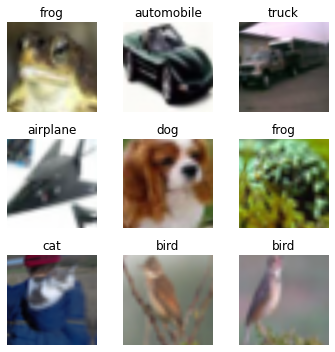

In [6]:
data.show_batch(rows=3, figsize=(5,5))

In [7]:
# Creating a learner with a pretrained ResNet50

learn = cnn_learner(data, models.resnet50, metrics=accuracy)

In [8]:
# Fitting the model

defaults.device = torch.device('cuda')
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,time
0,1.538226,0.863151,0.728333,08:58
1,1.193777,0.761407,0.760000,00:48
2,0.829188,0.538197,0.815000,00:48
3,0.627428,0.408680,0.880000,00:47
4,0.480991,0.367058,0.870000,00:48
5,0.398835,0.352728,0.885000,00:47
6,0.323037,0.294049,0.891667,00:47
7,0.274720,0.271727,0.898333,00:47
8,0.234158,0.272820,0.901667,00:47
9,0.212371,0.272046,0.905000,00:47


In [9]:
learn.save('img_classification')

In [10]:
learn.load('img_classification')

Learner(data=ImageDataBunch;

Train: LabelList (5400 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
airplane,airplane,airplane,dog,truck
Path: drive/My Drive/cifar10;

Valid: LabelList (600 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
automobile,truck,automobile,cat,bird
Path: drive/My Drive/cifar10;

Test: LabelList (10000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: drive/My Drive/cifar10, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=Fals

In [11]:
# Interpretation for model

interp = ClassificationInterpretation.from_learner(learn)

In [12]:
# False predictions

interp.most_confused(min_val=2)

[('cat', 'dog', 6),
 ('bird', 'airplane', 4),
 ('cat', 'frog', 4),
 ('dog', 'cat', 4),
 ('truck', 'automobile', 4),
 ('automobile', 'truck', 3),
 ('bird', 'deer', 3),
 ('bird', 'horse', 3),
 ('horse', 'deer', 3)]

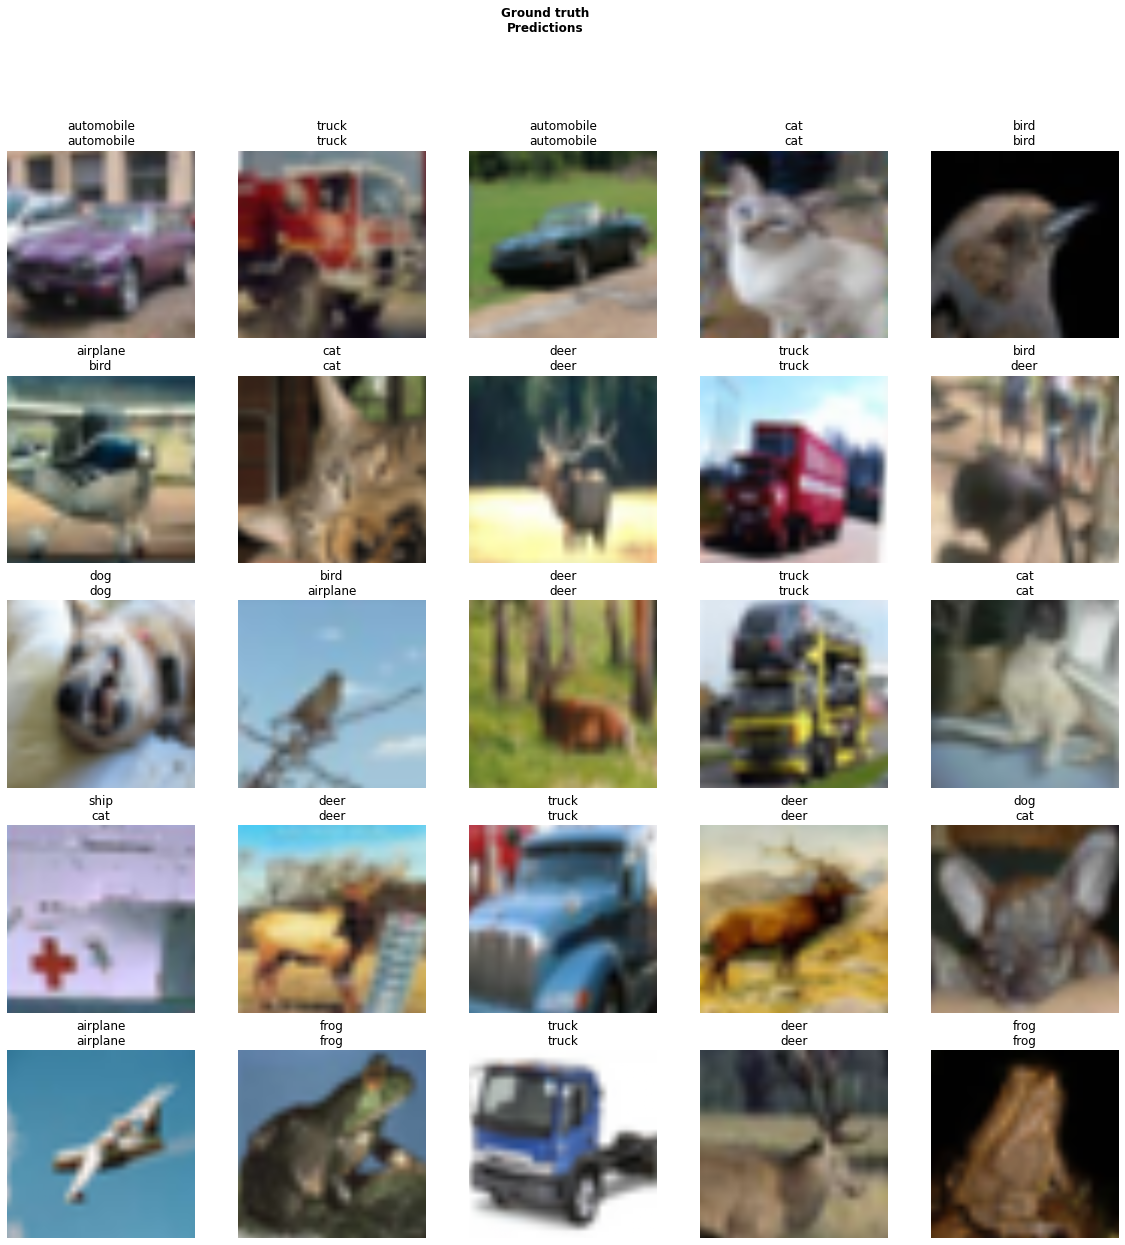

In [13]:
learn.show_results()

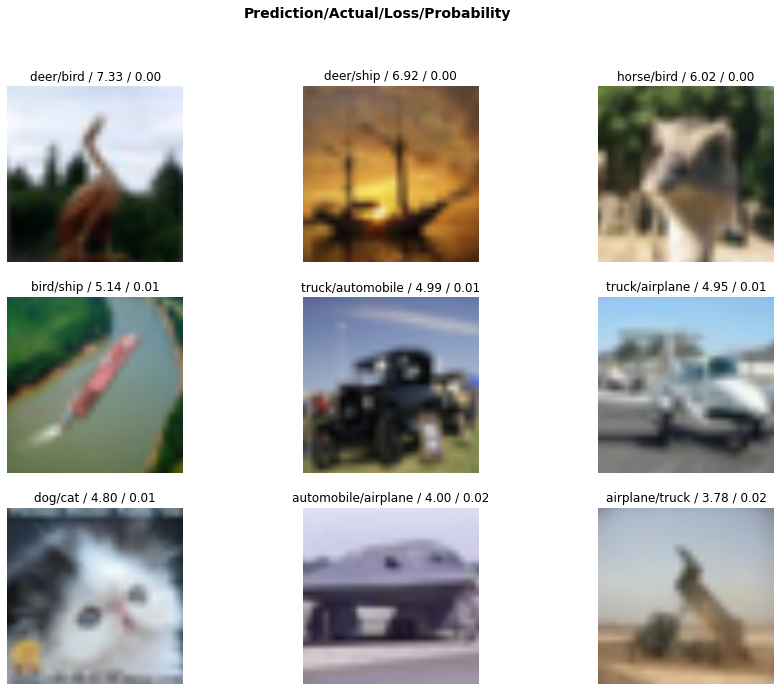

In [14]:
interp.plot_top_losses(9, figsize=(15,11))

In [18]:
len(data.valid_ds), len(data.train_ds), len(data.test_ds)

(600, 5400, 10000)

In [4]:
# Creating a data bunch for running test

data_test = (ImageList.from_folder(path)
        .split_by_folder(train='train', valid='test')
        .label_from_folder()
        .transform(get_transforms(), size=img_size)
        .databunch(bs=bs)
       )

In [5]:
data_test.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (50000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
airplane,airplane,airplane,airplane,airplane
Path: drive/My Drive/cifar10;

Valid: LabelList (10000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
deer,deer,deer,deer,deer
Path: drive/My Drive/cifar10;

Test: None

In [6]:
learn_test = cnn_learner(data_test, models.resnet50, metrics=accuracy).load('img_classification')

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [10]:
%%time
learn_test.validate(data_test.valid_dl)

CPU times: user 44 s, sys: 31.5 s, total: 1min 15s
Wall time: 48min 6s


[0.26187587, tensor(0.9098)]

In [14]:
time_req = 2886
batches = len(data_test.valid_ds) // bs; batches

156

In [17]:
interp_test = ClassificationInterpretation.from_learner(learn_test,ds_type=DatasetType.Valid)

In [15]:
def evaluate_model_from_interp(interp, data):
    # perform a "manual" evaluation of the model to take a look at predictions vs. labels and to
    # re-compute accuracy from scratch (to double check and also because I didn't find a quick way
    # to extract accuracy inside the guts of Fast.ai after a call to validate() on the test set...)
    print(f'Interp has {len(interp.y_true)} ground truth labels: {interp.y_true}')
    print(f'Interp yielded {len(interp.preds)} raw predictions. First two raw predictions are: {interp.preds[:2]}')
    print(f'The problem had {len(data.classes)} classes: {data.classes}') # data.c is just len(data.classes)
    
    print('')
    
    ok_pred = 0
    
    for idx, raw_p in enumerate(interp.preds):
        pred = np.argmax(raw_p)
        if pred == interp.y_true[idx]:
           ok_pred += 1
    
    acc = ok_pred / len(interp.y_true)
    latency = time_req / batches
    print(f'Overall accuracy of the model: {acc:0.5f}')
    print(f'Overall latency per batch of the model: {latency:0.5f}')

In [18]:
# Evaluating the model and printing out the accuracy & latency

evaluate_model_from_interp(interp_test, data_test)

Interp has 10000 ground truth labels: tensor([4, 4, 4,  ..., 3, 3, 3])
Interp yielded 10000 raw predictions. First two raw predictions are: tensor([[3.6385e-06, 1.3306e-06, 1.0979e-04, 1.2096e-05, 9.9976e-01, 1.6625e-05,
         5.8355e-05, 3.2733e-05, 3.4398e-06, 3.4967e-07],
        [4.5502e-09, 6.7615e-09, 1.8355e-08, 1.6235e-07, 1.0000e+00, 1.2011e-06,
         1.1751e-07, 9.0264e-08, 8.9277e-10, 9.8893e-10]])
The problem had 10 classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Overall accuracy of the model: 0.90980
Overall latency per batch of the model: 18.50000
